# Semi Supervised Email Categorization

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from gensim.models import Word2Vec


import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

# nltk.download("stopwords")
# nltk.download("punkt")

SEED = 56
np.random.seed(SEED)

## 02 Sampling the dataset`

In [30]:
# emails_dataframe = pd.read_csv('emails.csv')
# emails_sample = emails_dataframe.sample(n = 3000)
# emails_sample.to_csv('emails_3000.csv', index=False)
emails = pd.read_csv('emails_3000.csv')

## 03 Preprocessing

In [31]:
sample_email = emails['message'][0]
print(sample_email)

Message-ID: <1899108.1075841428486.JavaMail.evans@thyme>
Date: Mon, 4 Feb 2002 08:20:43 -0800 (PST)
From: jennifer.mcquade@enron.com
To: caroline.abramo@enron.com, tim.belden@enron.com, robert.benson@enron.com, 
	f..calger@enron.com, paul.choi@enron.com, chad.clark@enron.com, 
	mike.cowan@enron.com, mike.curry@enron.com, dana.davis@enron.com, 
	chris.dorland@enron.com, dale.furrow@enron.com, n..gilbert@enron.com, 
	fred.lagrasta@enron.com, john.llodra@enron.com, 
	michael.mcdonald@enron.com, h..otto@enron.com, m..presto@enron.com, 
	reagan.rorschach@enron.com, stewart.rosman@enron.com, 
	douglas.smith@enron.com, paul.thomas@enron.com, 
	barry.tycholiz@enron.com, larry.valderrama@enron.com, 
	frank.vickers@enron.com, greg.whalley@enron.com, 
	john.zufferli@enron.com
Subject: More Dial-in Numbers for 10:30 Meeting
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Mcquade, Jennifer </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JMCQUAD2>
X-To: Abramo, 

In [32]:
email_extensions = ['.com','.org','.in']

def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to','subject']
    
    for line in lines:
        if '****************************' in line:
            break
        
        if 'Original Message' in line:
            break
        
        if ':' not in line:
            if not(any(x in line for x in email_extensions)):
                temp = line.strip()
                temp = temp.lower()
                temp = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", temp)
                temp = re.sub(r"\s+", " ", temp)  # Remove multiple spaces in content
                temp = re.sub(r"\w+…|…", "", temp)  # Remove ellipsis (and last word)
                temp = re.sub('\d','',temp)
                temp = temp.translate(str.maketrans('','',string.punctuation))
                message += temp
                email['body'] = message    
        else:
            pair = line.split(':', maxsplit=1)
            key = pair[0].lower()
            value = pair[1].strip()
            # value = re.sub('\d','', value)
            value = value.translate(str.maketrans('','',string.punctuation))
            value = value.lower()
            if key in keys_to_extract:
                if key not in email.keys():
                    email[key] = value
    return email

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'from': map_to_list(emails, 'from'),
        'to': map_to_list(emails, 'to'),
        'subject': map_to_list(emails, 'subject'),
        'body': map_to_list(emails, 'body')
    } 

In [33]:
email_data = pd.DataFrame(parse_into_emails(emails['message']))
print(email_data.shape)
email_data.head()

(3000, 4)


,from,to,subject,body
0,jennifermcquadeenroncom,carolineabramoenroncom timbeldenenroncom rober...,more dialin numbers for 1030 meeting,just in case the first number i sent out does...
1,stevenkeanenroncom,bernadettehawkinsenroncom,constellation to build major plant in californ...,decade over a decade get over pages of da...
2,davidrosenbergenroncom,rodhayslettenroncom robertkilmerenroncom,by land or by sea,kilmer stopped in to discuss where we are on ...
3,jeffdasovichenroncom,dsteffesenroncom paulkaufmanenroncom dasovichj...,re sbx2 78 hearing canceled,thanks scott though the chances of re kind...
4,mikemcconnellenroncom,richardharperenroncom,re,richard life does move on what is malcomb t...


In [34]:
email_data = email_data[email_data['body'] != '']

In [35]:
email_data.shape

(2874, 4)

In [36]:
def top_features_tfidf(row, features, top = 20):
    top_ids = np.argsort(row)[::-1][:top]
    top_features = [(features[i], row[i]) for i in top_ids]
    return pd.DataFrame(top_features, columns=['features', 'score'])

def top_features_in_document(X, features, row_id, top = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_features_tfidf(row, features, top)

def top_features_corpus(X, features, group_ids = None, min_tfidf = 0.1, top = 20):
    if group_ids:
        doc = X[group_ids].toarray()
    else:
        doc = X.toarray()
        
    doc[doc < min_tfidf] = 0
    tfidf_means = np.mean(doc, axis=0)
    return top_features_tfidf(tfidf_means, features, top)

In [37]:
stop_words = ENGLISH_STOP_WORDS.union(['com','enron','ect','hou','thanks','attached','mail','email','week','image','doc','fw','fwd','know'])
vect = TfidfVectorizer(stop_words=stop_words, analyzer='word', min_df=2, max_df=0.5)
X = vect.fit_transform(email_data['body'])

In [38]:
X.shape

(2874, 12773)

In [39]:
features = vect.get_feature_names_out()
display(top_features_in_document(X, features, 1, 5))

,features,score
0,constellation,0.546699
1,plant,0.366400
2,nuclear,0.271199
3,energy,0.171742
4,scientech,0.162747


In [40]:
top_features_corpus(X, features, top=5)

,features,score
0,let,0.008266
1,schedule,0.008226
2,corp,0.008002
3,deal,0.007757
4,gas,0.007280


In [41]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=20):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_features_corpus(X, features, ids, min_tfidf=min_tfidf, top=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(20, 10), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [42]:
from sklearn.cluster import KMeans, MiniBatchKMeans

n_clusters = 4
clf = KMeans(n_clusters=n_clusters, max_iter=200, init='k-means++', n_init=1, algorithm='full')
labels = clf.fit_predict(X)

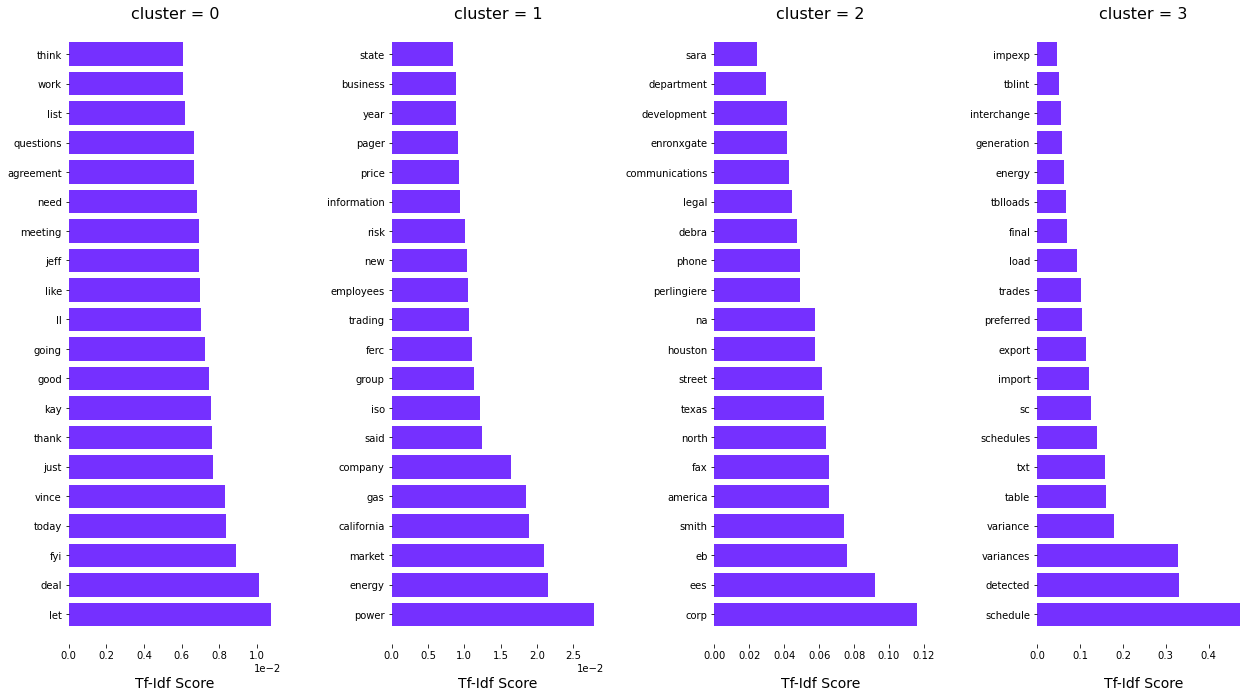

In [43]:
dfs = top_feats_per_cluster(X, labels, features, top_n=20)
plot_tfidf_classfeats_h(dfs)

In [49]:
def create_dataset_for_model(X, features, dfs, original_email_data, n_clusters, top = 20):
    labels = []
    for i in range(len(original_email_data)):
        top_features = top_features_in_document(X, features, i, top=top)
        common_sum_dict = {}
        
        for j in range(n_clusters):
            common_features = set(top_features['features']).intersection(set(dfs[j]['features']))
            if len(common_features) == 0:
                common_sum_dict[j] = 0
            else:
                common_sum_dict[j] = sum(top_features.loc[top_features['features'].isin(common_features)]['score'])
        
        max_cluster = max(common_sum_dict, key=lambda x: common_sum_dict[x])
        if common_sum_dict[max_cluster] < 0.01:
            label = 'other'
        else:
            label = dfs[max_cluster]['features'][0]
            if label == 'let':
                label = 'deal'
        
        labels.append(label)
    
    return {
        'data': original_email_data,
        'label': labels
    }       

In [50]:
final_df = pd.DataFrame(create_dataset_for_model(X, features, dfs, email_data['body'], n_clusters, top = 20))
final_df.shape

(2874, 2)

In [51]:
final_df['label'].value_counts()

other       936
deal        831
power       624
corp        379
schedule    104
Name: label, dtype: int64

In [53]:
final_df.to_csv('labelled_dataset.csv', index=False)

## 04 Model building

In [54]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [55]:
data = pd.read_csv('labelled_dataset.csv')
print(data.shape)
print(data['label'].value_counts())
data.head()

(2874, 2)
other       936
deal        831
power       624
corp        379
schedule    104
Name: label, dtype: int64


,data,label
0,just in case the first number i sent out does...,deal
1,decade over a decade get over pages of da...,power
2,kilmer stopped in to discuss where we are on ...,other
3,thanks scott though the chances of re kind...,other
4,richard life does move on what is malcomb t...,other


In [56]:
reduced_data = data
print(reduced_data.shape)
print(reduced_data['label'].value_counts())
reduced_data.head()

(2874, 2)
other       936
deal        831
power       624
corp        379
schedule    104
Name: label, dtype: int64


,data,label
0,just in case the first number i sent out does...,deal
1,decade over a decade get over pages of da...,power
2,kilmer stopped in to discuss where we are on ...,other
3,thanks scott though the chances of re kind...,other
4,richard life does move on what is malcomb t...,other


In [58]:
reduced_data['label'] = reduced_data['label'].astype('category')
reduced_data['label_id'] = reduced_data['label'].cat.codes
reduced_data.head()

,data,label,label_id
0,just in case the first number i sent out does...,deal,1
1,decade over a decade get over pages of da...,power,3
2,kilmer stopped in to discuss where we are on ...,other,2
3,thanks scott though the chances of re kind...,other,2
4,richard life does move on what is malcomb t...,other,2


In [59]:
id_to_label = pd.Series(reduced_data['label'].values,index=reduced_data['label_id']).to_dict()
id_to_label

{1: 'deal', 3: 'power', 2: 'other', 4: 'schedule', 0: 'corp'}

In [61]:
import tensorflow as tf

features, labels = reduced_data['data'], reduced_data['label_id']

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.7, test_size = 0.3, random_state = 3, stratify = labels)

X_train = np.asarray(X_train).astype(str)
X_test = np.asarray(X_test).astype(str)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.int64))
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.int64))

In [62]:
VOCAB_SIZE = 3000
max_len = 50

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=max_len, output_mode='int')
encoder.adapt(X_train)

In [63]:
vocab = np.array(encoder.get_vocabulary())
vocab[:25]

array(['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'for', 'enron',
       'is', 'i', 'that', 'you', 'on', 's', 'this', 'be', 'ect', 'with',
       'will', 'we', 'it', 'have', 'are'], dtype='<U24')

In [64]:
for example in X_train.take(3):
    print("Orignal: ", example.numpy())
    print("Round-trip: ", " ".join(vocab[encoder(example).numpy()]))
    print()

Orignal:  b' attached is the presentation and speech notes that ken lay used on wednesday  at the austin meeting with bush  etc '
Round-trip:  attached is the presentation and [UNK] notes that ken lay used on wednesday at the austin meeting with bush etc                              

Orignal:  b' apb shows this deal should be with mieco  thanks '
Round-trip:  [UNK] shows this deal should be with [UNK] thanks                                         

Orignal:  b' at its special meeting today  ferc released the results of its eagerly  awaited probe into california  s summer power crisis  concluding that under  certain circumstances  california ratepayers were subjected to unjust and  unreasonable power rates due to california  s  seriously flawed  market  structure and rules in conjunction with tight demand and supply conditions  throughout the west  the ferc staff report on western markets and the causes of the summer  price abormalities  entitled  part i of staff report on u  s  bulk 

In [65]:
encoder(example)

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([  28,   88,  516,  163,  136,  240, 1673,    2, 1032,    5,   88,
          1,    1,    1,  117,   59,   15,  311,   44,  546,    1,   12,
        162,  864, 1927,   59,    1,   86,    1,    3, 2549,    4, 2303,
         44,  354,  336,    3,   59,   15, 2431,    1,   62, 1272,    4,
        800,    7,    1,   19, 1951,  375], dtype=int64)>

In [66]:
train_dataset = tf.data.Dataset.zip((X_train, y_train))
test_dataset = tf.data.Dataset.zip((X_test, y_test))

In [67]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [68]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [69]:
def create_model():
    embedding = tf.keras.layers.Embedding(
    input_dim = len(encoder.get_vocabulary()),
    output_dim = 32,
    mask_zero = True)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (1,), dtype=tf.string))
    model.add(encoder)
    model.add(embedding)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(16, activation= 'relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-03),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

In [70]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 50, 32)            96000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 5)                 8

In [71]:
validation_dataset = test_dataset.take(100)
test_dataset = test_dataset.skip(100)

In [72]:
len(train_dataset), len(test_dataset), len(validation_dataset)

(2011, 763, 100)

In [ ]:
history = model.fit(train_dataset, epochs=20, verbose=1, validation_data=validation_dataset)

Epoch 1/20
2017/2017 [==============================] - 79s 35ms/step - loss: 1.3529 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2929 - val_sparse_categorical_accuracy: 0.4400
Epoch 2/20
2017/2017 [==============================] - 69s 34ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4600
Epoch 3/20
2017/2017 [==============================] - 67s 33ms/step - loss: 1.1481 - sparse_categorical_accuracy: 0.5568 - val_loss: 1.5194 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/20
2017/2017 [==============================] - 69s 34ms/step - loss: 1.0324 - sparse_categorical_accuracy: 0.6356 - val_loss: 1.0209 - val_sparse_categorical_accuracy: 0.5900
Epoch 5/20
2017/2017 [==============================] - 69s 34ms/step - loss: 0.9232 - sparse_categorical_accuracy: 0.6857 - val_loss: 1.1304 - val_sparse_categorical_accuracy: 0.5900
Epoch 6/20
2017/2017 [==============================] - 67s 33ms/step - loss: 0.

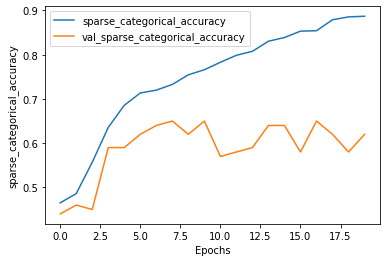

In [ ]:
plot_graphs(history, 'sparse_categorical_accuracy')

In [ ]:
score = model.evaluate(test_dataset, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  2.6946609020233154
Test accuracy:  0.6000000238418579


In [ ]:
id_to_label

{0: 'corp', 1: 'deal', 2: 'other', 3: 'power', 4: 'schedule'}

In [ ]:
for example, label in test_dataset.take(5):
    print('Original email: ', example.numpy()[0])
    print('Predicted label: ', id_to_label[np.argmax(model.predict(example.numpy()))])
    print('Actual  label: ', id_to_label[label.numpy()[0]])

Original email:  b' michael   tribolet  enron  enronxgate  steffes  na  enron  enron   david   w   delainey  hou  ees  ees  the   proposed   purchase   of   the   pge   and   sce  s   transmission   grids   have   vastly  different   short   term   liquidity   effects   for   pge   and   sce     if   the   current  proposal   is   at  23 x   book   and   assuming   the   first   mortgage   bond   holders   want  complete   repayment   in   return   for   releasing   their   liens   the   numbers   at  in   millions                     pge          sce  book   value                     143       190 multiple   of   book               23 x        23 x  cash   price                    329      437 first   mortgage   bonds         335      118 resulting   liquidity          006     319 note   that   the   first   mortgage   holders   may   release   their   liens   in   return   for  partial   payment   based   on   remaining   value    nonetheless   pge  s   situation   is  not   as   fle